# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loading Data

In [2]:
def load_data(filename, labels_present=True):

    data = pd.read_csv(filename)

    if labels_present:
        
        X = data.iloc[:,1:].to_numpy().astype("float32").reshape(-1,28,28)/255.0
        print("Training images shape:", X.shape)
        
        Y = data["label"].to_numpy().astype("float32").reshape(-1,)
        print("Training labels shape:", Y.shape)
        
        return X, Y
    
    else:
        
        X = data.iloc[:,1:].to_numpy().astype("float32").reshape(-1,28,28)/255.0
        print("Test images shape:", X.shape)
        
        ids = data["id"].to_numpy().astype("int").reshape(-1,)
        print("IDs shape:", ids.shape)
        
        return X, ids

In [3]:
# data_dir = "../input/Kannada-MNIST/"
data_dir = "./data/"

X, Y = load_data(data_dir + "train.csv")


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)


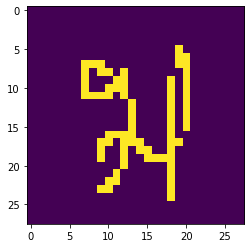

In [4]:
plt.imshow(X[5])
plt.show()

In [5]:
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

from tqdm import tqdm

c:\users\toby\appdata\local\programs\python\python36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper Functions


In [6]:
 
from torch.autograd import Variable

def get_device():
    if torch.cuda.is_available():
        return torch.device(f'cuda')
    else:
        return torch.device(f'cpu')
def cuda(v):
    if torch.cuda.is_available():
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):       
    return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if torch.cuda.is_available():
        return v.detach().cpu().numpy()
    return v.detach().numpy()

# Data Loaders

In [7]:
import random
import sys

# A dataset class that can be used by PyTorch data loaders
class CustomDataset(Dataset):
    
    def __init__(self, X, Y, num_classes=1, aug_transform=None):

        self.X = X
        # Convert labels to a tensor for training
        # self.Y = nn.functional.one_hot(toTensor(Y).long(), num_classes=num_classes)
        self.Y = toTensor(Y).long()
        
        X, Y = None, None

        self.xi_preprocessing_transform = transforms.Compose([
                                            transforms.ToTensor(),
                                          ])
        self.yi_preprocessing_transform = None
        self.aug_transform = aug_transform
        if self.aug_transform is not None:
            print("[WARNING]: Dataset loaded with augmentations set, make sure this is training only")
        
        self.nitems = self.X.shape[0]
        
        self.xi = None
        self.yi = None
        
    def __getitem__(self, index):

        X, Y = None, None # Avoiding accidently using X and Y instead of self.X

        xi = self.X[index]
        yi = self.Y[index]
        
        xi_final = xi
        yi_final = yi
        
        seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the transformations

        # First augment the data, if we have some augmentations to apply
        if self.aug_transform is not None:
            random.seed(seed)

            trans_dict = self.aug_transform(image=xi)
            # Apply to the images before doing standard transforms
            xi = trans_dict["image"]

        # Convert examples to a tensor
        if self.xi_preprocessing_transform is not None:
            random.seed(seed) # apply this seed to img transforms
            xi_final = self.xi_preprocessing_transform(xi)

        return xi_final,  yi_final
    
    def __len__(self):
        return self.nitems

# Model Zoo

## BasicCNN

In [8]:

class ConvNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(ConvNet, self).__init__()

        self.num_classes = num_classes

        self.name = "ConvNet"

        layer1_kernel_num = 16
        self.layer1 = nn.Sequential(

            # Kernel details
            nn.Conv2d(in_channels, layer1_kernel_num, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(layer1_kernel_num),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        layer2_kernel_num = 32
        self.layer2 = nn.Sequential(
            nn.Conv2d(layer1_kernel_num, layer2_kernel_num, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(layer2_kernel_num),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc1 = nn.Linear(7*7*layer2_kernel_num, num_classes)

        self.output_layer = nn.Softmax(dim=1)

        print("Model initialised.")

    def forward(self, x):

        out = self.layer1(x)

        out = self.layer2(out)

        # Flatten output of Conv part
        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.output_layer(out)
        return out

## LargerCNN

In [9]:
class ConvNetLarge(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(ConvNetLarge, self).__init__()

        self.num_classes = num_classes

        self.name = "ConvNetLarge"

        layer1_kernel_num = 64
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, layer1_kernel_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(layer1_kernel_num),
            nn.LeakyReLU(negative_slope=0.1),
            # nn.MaxPool2d(kernel_size=2, stride=2)
            )

        layer2_kernel_num = 64
        self.layer2 = nn.Sequential(
            nn.Conv2d(layer1_kernel_num, layer2_kernel_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(layer2_kernel_num),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        layer3_kernel_num = 128
        self.layer3 = nn.Sequential(
            nn.Conv2d(layer2_kernel_num, layer3_kernel_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(layer3_kernel_num),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        layer4_kernel_num = 128
        self.layer4 = nn.Sequential(
            nn.Conv2d(layer3_kernel_num, layer4_kernel_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(layer4_kernel_num),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

#         self.fc1 = nn.Sequential(
#             nn.Linear(1152, 256),
#             nn.Dropout(p=0.2)
#             )
        
        self.fc1 = nn.Linear(1152, num_classes)

        self.output_layer = nn.Softmax(dim=1)

        print("Model initialised.")

    def forward(self, x):

        out = self.layer1(x)

        out = self.layer2(out)
        
        out = self.layer3(out)
        
        out = self.layer4(out)

        # Flatten output of Conv part
        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.output_layer(out)
        return out

In [10]:
# Code which goes through the results collected during training and plots them.
def plotResults(trainingResults):

    metrics_available = trainingResults[list(trainingResults.keys())[0]].keys()

    for i, metric in enumerate(metrics_available):
        
        plt.figure(figsize=(10,5))

        plt.title(metric + " over the course of training")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        # Values were recorded for train and validation results
        for phase in trainingResults.keys():

            epochs = len(trainingResults[phase][metric])
            epochs_range = range(1,epochs+1)

            plt.plot(epochs_range,trainingResults[phase][metric],label=phase)

        plt.legend()
        plt.show()

In [11]:
def count_correct(preds, labels, debug=False):

    correct_count = 0.0
    
    predicted_labels = torch.argmax(preds, dim=1)
    correct_count += (predicted_labels == labels).sum().item()
    
    if debug:
        print("Predicted:",toNumpy(predicted_labels))
        print("Labels:",toNumpy(labels))
        print("Correct Count:",correct_count)
    
    return correct_count

In [12]:
# import albumentations as AUGS
# from sklearn import metrics

def train(model_class,model_init_params,Xtr,Ytr,valSplitSize=0.2,batch_size=32,num_epochs=20,lr=1e-3,verbose=0):
    
    X, Y = None, None
    
    trainSize = int((1.0 - valSplitSize)*len(Xtr))
    print("Train set size:",trainSize)
    # Validation set
    Xv, Yv = Xtr[trainSize:], Ytr[trainSize:]
    # Train set
    Xtr, Ytr = Xtr[:trainSize], Ytr[:trainSize]

    print("Training Dataset sizes:","[", Xtr.shape, Ytr.shape,"]")
    print("Validation Dataset sizes:","[", Xv.shape, Yv.shape,"]")
    
    device = get_device()
    
    model = model_class(**model_init_params).to(device)
    print("Model Loaded:",model.name)
    
#     aug_transform = AUGS.Compose([
#       # Vertical flipping
#       # AUGS.VerticalFlip(),
#       # AUGS.HueSaturationValue(p=0.2),       
#       # AUGS.RandomBrightness(limit=0.2)
#       AUGS.Affine(translate_percent=(0.0, 0.2), p=0.2),
#       AUGS.Blur(blur_limit=3, always_apply=False, p=0.3),
#       AUGS.ColorJitter(p=0.7),
#       ])
    
    aug_transform=None
    
    # Make datasets
    train_dataset = CustomDataset(Xtr, Ytr, num_classes=model.num_classes, aug_transform=aug_transform)
    val_dataset = CustomDataset(Xv, Yv, num_classes=model.num_classes)
    
    # Make loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=0) 
    
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=0) 
    
    criterion = nn.CrossEntropyLoss()
    print("Loss Function:",criterion)
    
    # Uses our learning rate parameter
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    results = dict()
    for phase in ["training","validation"]:
        results[phase] = {"loss": [], "accuracy": []}
    
    lowestValidationAcc = np.NINF
    
    # Train the model
    for epoch in range(num_epochs):
        
        results_this_epoch = dict()
        for phase in ["training","validation"]:
            results_this_epoch[phase] = {"loss": [], "accuracy": []}
        
        # Needed since we switch to .eval() during the validation stage
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader)):

            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            preds = model(images)
            
            loss = criterion(preds, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            results_this_epoch["training"]["loss"].append(loss.item())
            results_this_epoch["training"]["accuracy"].append(count_correct(preds, labels))
            
        # Validation
        
        # Making sure we aren't using dropouts and also aren't training the model
        model.eval()
        with torch.no_grad():
            
            for i, (images, labels) in enumerate(tqdm(val_loader)):

                images = images.to(device)
                labels = labels.to(device)
                # Forward pass
                preds = model(images)

                loss = criterion(preds, labels)
                # No update step

                results_this_epoch["validation"]["loss"].append(loss.item())
                results_this_epoch["validation"]["accuracy"].append(count_correct(preds, labels))
            
        print('Epoch [{}/{}]'.format(epoch+1, num_epochs))

        for phase in results_this_epoch.keys():
            for metric in results_this_epoch[phase].keys():
                if metric == "loss":
                    results[phase][metric].append(np.mean(results_this_epoch[phase][metric]))
                elif metric == "accuracy":
                    if phase == "training":
                        total = len(Ytr)
                    elif phase == "validation":
                        total = len(Yv)
                    results[phase][metric].append(np.sum(results_this_epoch[phase][metric])/total)
                    
                if (verbose > 0):
                    print('[{}] {}: {:.4f}'.format(phase, metric, results[phase][metric][-1]))
                
        # Early stopping, preventing overfitting when using too many epochs        
        if results["validation"]["accuracy"][-1] > lowestValidationAcc:
            lowestValidationAcc = results["validation"]["accuracy"][-1]
            if verbose > 0:
                print("  **")
            state = {'epoch': epoch + 1,
                     'model_dict': model.state_dict(),
                     'params': model_init_params,
                     'best_loss_on_test': lowestValidationAcc}

            modelLocation = model.name + "_best_model.pth"
            torch.save(state, modelLocation) # saves to current directory
            if verbose > 0:
                  print("Model information (including weights) saved to:",modelLocation)
                    
    plotResults(results)
    
    # Load up saved model
    model = model_class(**model_init_params).to(device)
    model.load_state_dict(torch.load(modelLocation,map_location=torch.device(device))["model_dict"])
    model.eval()
    
    return model


Train set size: 80
Training Dataset sizes: [ (80, 28, 28) (80,) ]
Validation Dataset sizes: [ (20, 28, 28) (20,) ]
Model initialised.
Model Loaded: ConvNet
Loss Function: CrossEntropyLoss()


100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


Epoch [1/10]
[training] loss: 2.3088
[training] accuracy: 0.1000
[validation] loss: 2.2996
[validation] accuracy: 0.1000
  **
Model information (including weights) saved to: ConvNet_best_model.pth


100%|██████████| 1/1 [00:00<00:00, 28.13it/s]


Epoch [2/10]
[training] loss: 2.2227
[training] accuracy: 0.3375
[validation] loss: 2.2957
[validation] accuracy: 0.3500
  **
Model information (including weights) saved to: ConvNet_best_model.pth


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


Epoch [3/10]
[training] loss: 2.1270
[training] accuracy: 0.5625
[validation] loss: 2.2910
[validation] accuracy: 0.6000
  **
Model information (including weights) saved to: ConvNet_best_model.pth


100%|██████████| 1/1 [00:00<00:00, 25.15it/s]


Epoch [4/10]
[training] loss: 2.0276
[training] accuracy: 0.6500
[validation] loss: 2.2860
[validation] accuracy: 0.6500
  **
Model information (including weights) saved to: ConvNet_best_model.pth


100%|██████████| 1/1 [00:00<00:00, 21.87it/s]


Epoch [5/10]
[training] loss: 1.9285
[training] accuracy: 0.7375
[validation] loss: 2.2804
[validation] accuracy: 0.5500


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


Epoch [6/10]
[training] loss: 1.8372
[training] accuracy: 0.8000
[validation] loss: 2.2739
[validation] accuracy: 0.6000


100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


Epoch [7/10]
[training] loss: 1.7622
[training] accuracy: 0.8250
[validation] loss: 2.2666
[validation] accuracy: 0.6000


100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


Epoch [8/10]
[training] loss: 1.7018
[training] accuracy: 0.8875
[validation] loss: 2.2583
[validation] accuracy: 0.7000
  **
Model information (including weights) saved to: ConvNet_best_model.pth


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


Epoch [9/10]
[training] loss: 1.6449
[training] accuracy: 0.8875
[validation] loss: 2.2487
[validation] accuracy: 0.8000
  **
Model information (including weights) saved to: ConvNet_best_model.pth


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


Epoch [10/10]
[training] loss: 1.6056
[training] accuracy: 0.9125
[validation] loss: 2.2370
[validation] accuracy: 0.8000


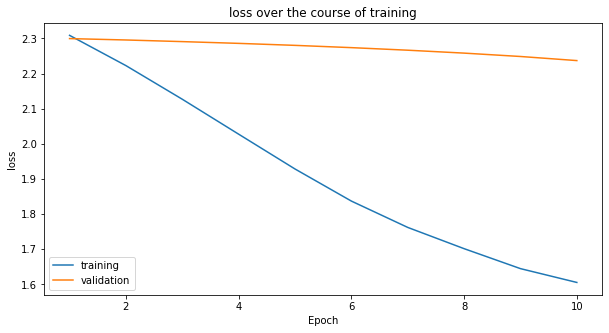

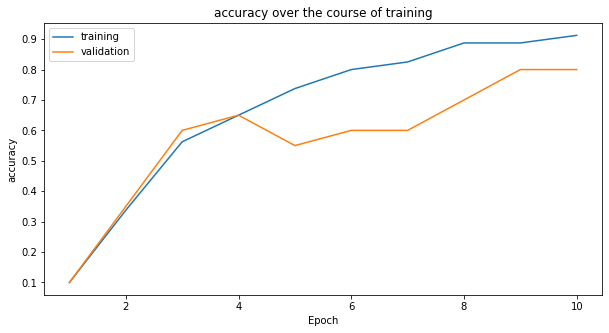

Model initialised.


In [13]:
# BasicCNN
trained_model = train(ConvNet,{},X[:100],Y[:100],verbose=1,num_epochs=10, batch_size=256, lr=1e-3, valSplitSize=0.2)
# LargeCNN
# trained_model = train(ConvNetLarge,{},X,Y,verbose=1,num_epochs=15, batch_size=256, lr=1e-3, valSplitSize=0.2)

In [14]:
def infer_raw(filename, model):
    
    device = get_device()

    X, ids = load_data(filename, labels_present=False)

    dataset = CustomDataset(X, np.zeros((len(X),)), num_classes=model.num_classes)

    X = None # Free X

    # Make loaders
    data_loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=0) 

    predicted_labels = np.asarray([],dtype="int")
    
    model.eval()
    with torch.no_grad():

        for i, (images, _) in enumerate(tqdm(data_loader)):

            images = images.to(device)
            # Forward pass
            preds = model(images)
            
            predicted_labels = np.concatenate( (predicted_labels, toNumpy(torch.argmax(preds, dim=1))) )            
            
    predicted_labels = predicted_labels.reshape(-1,1)
    ids = ids.reshape(-1,1)
    
    return pd.DataFrame( np.concatenate( (ids, predicted_labels), axis=1 ), columns = ["id","label"] )

In [15]:
results = infer_raw(data_dir + "test.csv", trained_model)
results.to_csv("./submission.csv", index=False)

Test images shape: (5000, 28, 28)
IDs shape: (5000,)


100%|██████████| 40/40 [00:04<00:00,  9.84it/s]
